In [277]:
import pandas as pd
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import csv
from io import StringIO
from imblearn.under_sampling import RandomUnderSampler
import io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm
import nltk
import sys
from scipy.stats import t
from scipy import stats
import statsmodels.api as sa
import statsmodels.formula.api as sfa
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
from sklearn.compose import ColumnTransformer
from sklearn import linear_model
from sklearn import svm
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import StackingClassifier
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.svm import SVC
from sklearn.ensemble import  AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import TruncatedSVD
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
from sklearn.base import BaseEstimator

class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass

# 1.0 Read Data

In [3]:
#user_engagement
ue = pd.read_csv('takehome_user_engagement.csv')

In [7]:
#users
us = pd.read_csv('takehome_users.csv',encoding = 'latin-1')

# 1.1 Adopted User Calculation

In [23]:
#convert to datetime
ue['time_stamp'] = pd.to_datetime(ue['time_stamp'])

In [244]:
#shift timestamp so that the row from row above to row below
ue['time_stamp_shift'] = ue.groupby('user_id').time_stamp.shift()
ue['time_stamp_shift_2'] = ue.groupby('user_id').time_stamp_shift.shift()

In [245]:
#find how many days passed between timestamp and timstamp shift
ue['time_dif'] = ue['time_stamp'] - ue['time_stamp_shift_2']
#ue['time_dif'] = ue['time_stamp_shift'] - ue['time_stamp_shift']

In [246]:
#convert to float
ue['time_int'] = ue['time_dif']/ np.timedelta64(1, 'D')

In [253]:
#aggregate by user id and then sum up time_int ie.
#time_int: the minimum difference between their first session and third session  in days.
#visits: number of visits on site by user
ue_final = ue[['user_id','time_int','visited']].groupby('user_id').agg({'time_int':'min', 'visited': 'sum'}).reset_index().fillna(0)

In [263]:
#Merge grouped ue_final into the us data
us_merged = us.merge(ue_final,left_on = 'object_id',right_on = 'user_id',how = 'left')

In [264]:
us_merged.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,time_int,visited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0,0.0,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2.0,5.0,14.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,3.0,0.0,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,4.0,0.0,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,5.0,0.0,1.0


In [265]:
# if time_int is between 1 and 7 days and there are more than 3 visits
us_merged['adopted_user'] = us_merged.apply(lambda x: 1 if x['time_int'] <= 7 and x['time_int'] > 0 and x['visited'] >= 3 else 0, axis = 1)

# 1.2 Feature Engineering

In [266]:
#convert to time date
us_merged['creation_time'] = pd.to_datetime(us_merged.creation_time)

In [267]:
#month
us_merged['creation_month'] = us_merged.creation_time.dt.month

In [268]:
#day of week
us_merged['creation_dow'] = us_merged.creation_time.dt.dayofweek

In [270]:
#convert from unix to date time
us_merged['last_session_time'] = pd.to_datetime(us_merged['last_session_creation_time'],unit = 's')

In [271]:
#month for last session
us_merged['last_session_month'] = us_merged['last_session_time'].dt.month.astype(str).fillna("unknown")

In [272]:
#month for day of week for last session
us_merged['last_session_dow'] = us_merged['last_session_time'].dt.dayofweek.astype(str).fillna("unknown")

In [273]:
#week of the month for last session (1,2,3,4)
us_merged['last_session_wom'] = ((us_merged['last_session_time'].dt.day - 1)/7).round(0).astype(str).fillna("unknown")

In [274]:
#get email provider (google.com, hotmail.com)
us_merged['email_provider'] = us_merged.email.str.extract('@(.*)(\.)(.*)')[0].str.strip()

In [275]:
us_merged['invited_by_user_id'] = us_merged.invited_by_user_id.astype(str).fillna("unknown")

In [276]:
us_merged[['adopted_user']].groupby('adopted_user').size()

adopted_user
0    10344
1     1656
dtype: int64

# 1.3 Exploratory Analysis

In [299]:
import seaborn as sns

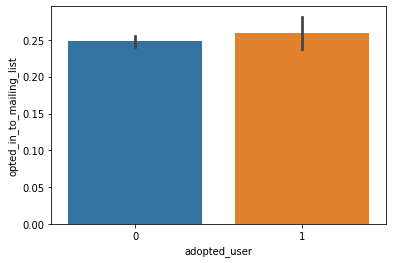

In [306]:
sns.barplot(x = "adopted_user", y = 'opted_in_to_mailing_list', data = us_merged)

__Note #1:__ It seems that adopted_users have a bit higher probability to have opted in mailing list but the confidence interval is so wide for the adopted users that the results might not be statistically significant.

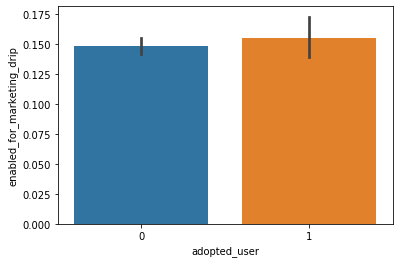

In [307]:
sns.barplot(x = "adopted_user", y = 'enabled_for_marketing_drip', data = us_merged)

__Note #2:__ It seems that adopted_users have a bit higher probability to be enabled for marketing drip but the confidence interval is so wide for the adopted users that the results might not be statistically significant.

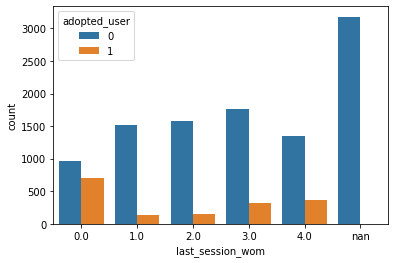

In [308]:
sns.countplot(x = "last_session_wom", hue = 'adopted_user', data = us_merged)

__Note #3:__ You can see that there are more adopted users during the first week of the month relative to other  months.

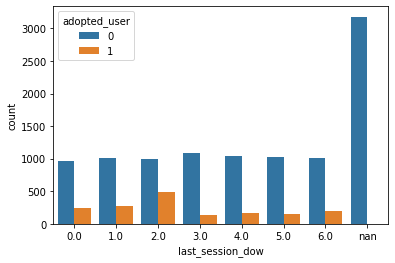

In [309]:
sns.countplot(x = "last_session_dow", hue = 'adopted_user', data = us_merged)

__Note #4:__  There are high number of users who don't seem to have logged in after creation. On top of that, we see that there are more adopted users during day 1 and 2 (Tuesday and Wednesday).

# 2.0 Modeling

In [278]:
y = us_merged.adopted_user

In [279]:
X = us_merged.drop(['email','user_id','object_id','name','email','last_session_creation_time','creation_time',
                    'last_session_time','adopted_user','time_int','visited'],axis = 1)

# 2.1  Undersampling/ Train and  Test Split

In [280]:
undersample = RandomUnderSampler(sampling_strategy='majority')


In [281]:
X_over, y_over = undersample.fit_resample(X, y)

In [282]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3, random_state=42) #test_train model

# 2.2 Pipeline

In [284]:
categorical_features = ['creation_source','org_id','invited_by_user_id','creation_month','creation_dow','last_session_month','last_session_dow','last_session_wom','email_provider']
categorical_transformer = Pipeline(steps=[
   ('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

In [285]:
numeric_features = ['opted_in_to_mailing_list','enabled_for_marketing_drip']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

In [286]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
         ('num', numeric_transformer,numeric_features)])

In [287]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('clf', DummyEstimator())])

In [288]:
search_space = [ #input 8 classifiers 
                    
                 {
                  'clf': [xgb.XGBClassifier()]},
                {
                 'clf': [RandomForestClassifier(max_depth=5,random_state=0)]
                } ,

    
                {
                  'clf':[AdaBoostClassifier()]},
            
                {
                    'clf': [LogisticRegression()]},

                                

]

In [289]:
grid = GridSearchCV(pipe, cv=5, param_grid=search_space,error_score = 0,verbose = 10, n_jobs = -1)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:   14.4s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   14.8s finished


GridSearchCV(cv=5, error_score=0,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['creation_source',
                                                                          'org_id',
                                                                          'invited_by_user_id',
                                                                          'creation_month',
                                                                          'creation_dow',
                                                                          'last_session_month',
                                              

In [290]:
print("Best: %f using %s" % (grid.best_score_, 
    grid.best_params_))

Best: 0.904230 using {'clf': XGBClassifier()}


In [291]:
pipe.set_params(**grid.best_params_)
pipe.fit(X_train,y_train)
y_preds = pipe.predict(X_test)


In [292]:
print('Accuracy score on test set %.3f' % accuracy_score(y_test, y_preds))

Accuracy score on test set 0.895


# 3.0 Confusion Matrix

In [293]:

print(confusion_matrix(y_test, y_preds, labels=range(2)))
print(classification_report(y_test, y_preds))

[[499  22]
 [ 82 391]]
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       521
           1       0.95      0.83      0.88       473

    accuracy                           0.90       994
   macro avg       0.90      0.89      0.89       994
weighted avg       0.90      0.90      0.89       994



# 4.0 Features Importance

In [294]:
dooh_col_names = preprocessor.transformers_[0][1]['onehot'].get_feature_names(categorical_features).tolist()

In [295]:
num_cols = X.select_dtypes('int64').columns.tolist()[0:2]

In [296]:
col_f = num_cols+ dooh_col_names

In [297]:
import eli5

In [298]:
eli5.show_weights(pipe[1],top = 50, feature_names = col_f)

Weight,Feature
0.1468,last_session_month_3.0
0.1278,last_session_month_8.0
0.1192,last_session_month_4.0
0.0688,creation_month_3
0.0646,last_session_dow_6.0
0.0425,invited_by_user_id_nan
0.0371,creation_month_6
0.0362,creation_month_4
0.0330,last_session_month_12.0
0.0310,last_session_month_2.0


As you see, the most important variables for predicting adopted usage is whether people logged in month 3,4,8 (March, April, and August) are major predictors of adopted usage. Also if people logged in on Sunday and people who weren't invited to join the site by anyone are major positive predictors of adopted usage. 